# Importation

In [12]:
import cv2
import numpy as np
import os
import time
import warnings
import sys
import re
from nltk import download
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import pos_tag, RegexpParser, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

from PyPDF2 import PdfReader
from PIL import ImageGrab, Image
import fitz
import pytesseract
from pdf2image import convert_from_path
import pyautogui

# This Python environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here are several helpful packages to load in
import easyocr
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Transforming to pictures

In [9]:
# PDF file paths
pdfPMBOK = "PMBOK6-2017.pdf" #431-494
pdfPMI = "practice-standard-project-risk-management.pdf" #1-116
output_folder_1="PMBOOKimgs"
output_folder_2="Practiceimgs"

In [42]:
def convert_pdf_to_images(pdf_file_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_file_path, output_folder=output_folder, fmt='png', first_page=start_page, last_page=end_page, output_file="page")

    print("Done.")

In [43]:
convert_pdf_to_images(pdfPMBOK, output_folder_1, 431, 494)

Done.


In [44]:
convert_pdf_to_images(pdfPMI, output_folder_2, 1, 116)

Done.


# Extracting Figures

### YOLO: (does not work)

###### must install yolov3.weights yolov3.cfg coco.names (ask chatgpt)

In [80]:
import cv2
import numpy as np

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load class names
with open("coco.names", "r") as f:
    classes = f.read().strip().split("\n")

# Load image
img = cv2.imread("PMBOOKimgs/page0001-446.png")
height, width, channels = img.shape

# Perform object detection
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(net.getUnconnectedOutLayersNames())

# Information to store detected objects
class_ids = []
confidences = []
boxes = []

# Minimum confidence threshold
conf_threshold = 0.5

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-maximum suppression to remove overlapping boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Capture screenshots of detected objects
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]

        # Draw bounding box and label on the image
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Crop the object and save it as a screenshot
        object_roi = img[y:y + h, x:x + w]
        cv2.imwrite(f"{label}.png", object_roi)

# Scale factor for display
scale_factor = 0.3  # Adjust this value as needed

# Resize the image
resized_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)

# Display the resized image with bounding boxes
cv2.imshow("Image", resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [103]:
yolo_object_detection("PMBOOKimgs/page0001-432.png")

NameError: name 'yolo_object_detection' is not defined

### openCV:

In [26]:
def detect_shapes(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread("PMBOOKimgs/"+image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    k=0
    for contour in contours:
        k=k+1
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Define a region of interest (ROI) using the rectangle coordinates
                roi = image[y:y+h, x:x+w]

                # Save the ROI as an image for inspection
                cv2.imwrite("screenshots/"+image_path+"/"+str(k)+"detected__"+image_path, roi)                
                

In [123]:
detect_shapes("page0001-445.png")

In [124]:
for k in os.listdir("PMBOOKimgs/"):
    os.makedirs("screenshots/"+k, exist_ok=True)
    detect_shapes(k)

# Extracting Texts from images

### Using Pytesseract from imgs:

In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\hamma\AppData\Local\Tesseract-OCR\tesseract.exe'

In [41]:
def extract_text(image_path):
    # Read the image
    image = cv2.imread(image_path)
    

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to segment text from the background
    _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove horizontal and vertical lines using morphological operations
    kernel = np.ones((4, 4), np.uint8)
    clean_image = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    text = pytesseract.image_to_string(Image.fromarray(threshold))


    print(text)
    # Save the extracted text to a file
    #with open(output_text_path, 'w', encoding='utf-8') as text_file:
        #text_file.write(text)

In [44]:
extract_text("screenshots/page0001-446.png/54detected__page0001-446.png")

Project
Management
Plan

Project management plan

« Requirements management plan
« Schedule management plan
« Cost management plan

« Resource management plan
* Quality management plan
« Risk management plan
« Scope baseline

* Schedule baseline

* Cost baseline

Project
Documents

reject documents
Assumption log
Cost estimates 11.2

Issue log Risks
Lessons learned register

Project
eceeeseserseseeseneces: Docurnents

Risk register
* Risk report

Requirements documentation
Resource requirements.
Stakeholder register

Pr
.
.
* Duration estimates Identify
.
.
.
.
.

12.1
Plan
Procurement
Management

Procurement documentation

12.2
Conduct
Procurements

Agreements

Enterprise/
Organization

Enterprise environmental factors.
Organizational process assets

Project documents updates
« Assumption log

* Issue log

« Lessons learned register




###### either extracts everything or extract without figures but wrong

# Extracting Texts from pdf

#### Fitz

##### extracting titles 

In [558]:
import fitz  # PyMuPDF
import re
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_titles_and_descriptions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    titles_with_descriptions = []

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text=page_text.replace('—','\n')

        # Utilisez une expression régulière pour rechercher des motifs de titre "11.x" ou "11.x.x" ou "11.x.x.x"
        matches = re.findall(r'(11+(\.\d+)+)\s+(.+)', page_text)
        for match in matches:
            title = match[0]
            description = match[2]

            # Prédire la partie manquante de la description en utilisant BERT
            masked_text = f"[MASK] {description}"
            input_ids = tokenizer.encode(masked_text, add_special_tokens=True, return_tensors="pt")
            mask_index = input_ids[0].tolist().index(tokenizer.mask_token_id)

            with torch.no_grad():
                predictions = model(input_ids)
            predicted_token_id = torch.argmax(predictions.logits[0, mask_index]).item()
            predicted_word = tokenizer.decode(predicted_token_id)

            # Remplacez le masque par le mot prédit dans la description
            description = description.replace("[MASK]", predicted_word)

            # Ajoutez le titre et la description complète à la liste
            titles_with_descriptions.append(f"{title} {description}")

    pdf_document.close()
    return titles_with_descriptions

# Exemple d'utilisation
pdf_file_path = 'PMBOK6-2017.pdf'
titles_with_descriptions = extract_titles_and_descriptions_from_pdf(pdf_file_path)

# Imprimez les titres avec les descriptions complètes
for title_with_description in titles_with_descriptions:
    print(title_with_description)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11.1 Plan Risk Management ..............................................................................................401
11.1.1 Plan Risk Management: Inputs ......................................................................402
11.1.2 Plan Risk Management: Tools and Techniques .............................................404
11.1.3 Plan Risk Management: Outputs ...................................................................405
11.2 Identify Risks ..............................................................................................................409
11.2.1 Identify Risks: Inputs .....................................................................................411
11.2.2 Identify Risks: Tools and Techniques ............................................................414
11.2.3 Identify Risks: Outputs ...................................................................................417
11.3 Perform Qualitative Risk Analysis .........................................

##### extracting Texts 

In [559]:
import fitz  # PyMuPDF
import re
import pandas as pd  # Import Pandas
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_concepts_and_definitions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    concepts_and_definitions = []
    current_concept = ""
    current_definition = ""

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text = page_text.replace('—', '\n')

        # Split the page text into lines
        lines = page_text.split("\n")

        for line in lines:
            # Check if the line matches the pattern for a concept
            if re.match(r'(11+(\.\d+)+)\s+(.+)', line):
                if current_concept:
                    # Append the current concept and definition to the list as a tuple
                    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
                
                # Split the line into concept and definition
                concept_match = re.match(r'(11+(\.\d+)+)\s+(.+)', line)
                current_concept = concept_match.group(1)
                current_concept_name = concept_match.group(3)
                current_definition = ""
            else:
                # If the line does not match the pattern, consider it part of the definition
                current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
    pdf_document.close()

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
pdf_file_path = 'PMBOK6-2017.pdf'
df = extract_concepts_and_definitions_from_pdf(pdf_file_path)

# Print or process the DataFrame
df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Number,Concept,Definition
0,11.1,Plan Risk Management ............................,
1,11.1.1,Plan Risk Management: Inputs ....................,
2,11.1.2,Plan Risk Management: Tools and Techniques ......,
3,11.1.3,Plan Risk Management: Outputs ...................,"\n\nNot For Distribution, Sale or Reproduction..."
4,11.2,Identify Risks ..................................,
...,...,...,...
154,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
155,11.7.3.2,CHANGE REQUESTS,\nDescribed in Section 4.3.3.4. The Monitor Ri...
156,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nAny change to the project management plan go...
157,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


##### =>>>>>>>>bad result

In [555]:
import fitz
import pandas as pd

def extract_plain_text_from_pdf(pdf_file_path):
    # Open the PDF file
    pdf_document = fitz.open(pdf_file_path)

    # Initialize an empty list to store the extracted data
    data = []

    for page_number in range(431, 495):
        page = pdf_document.load_page(page_number)
        text = page.get_text()
        blocks = text.split("\n")

        # Initialize variables to store the current title and description
        current_title = ""
        current_description = ""

        for block in blocks:
            block = block.strip()

            if "Figure" in block:
                continue
            elif block.isupper():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.istitle():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.startswith("- "):
                continue
            else:
                # Append the block to the current description
                current_description += block + "\n"

        # Add the last title and description to the data list
        if current_title:
            data.append({"title": current_title, "description": current_description})

    # Close the PDF document
    pdf_document.close()

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    return df


In [556]:
# Extract plain text and create DataFrame
df = extract_plain_text_from_pdf(pdfPMBOK)

In [557]:
df

,title,description
0,Part 1 - Guide,
1,.1 Inputs,.1 Project charter\n.2 Project management plan...
2,.2 Tools & Techniques,.1 Expert judgment\n.2 Data analysis\n
3,.3 Meetings,
4,.3 Outputs,.1 Risk management plan\n
...,...,...
476,11.7.3.3 PROJECT MANAGEMENT PLAN UPDATES,Any change to the project management plan goes...
477,Part 1 - Guide,
478,11.7.3.4 PROJECT DOCUMENTS UPDATES,Project documents that may be updated as a res...
479,11.7.3.5 ORGANIZATIONAL PROCESS ASSETS UPDATES,Organizational process assets that are updated...


In [14]:
df.to_excel("data.xlsx", index=False)

# Returning to extracting from imgs:

#### we thought about covering figures with black screen and reading the rest using EasyOCR & cv2

# deleting figures in on  image

In [11]:
def detect_and_remove_rectangles(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same size as the image, initialized to white
    mask = np.ones_like(image) * 255

    for contour in contours:
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Set the region corresponding to the rectangle to black in the mask
                mask[y:y+h, x:x+w] = 0

    # Use the mask to copy the non-rectangle parts of the image to a new image
    result = cv2.bitwise_and(image, mask)

    return result


# Get a list of all image files in the folder
image_files = [f for f in os.listdir(output_folder_1) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Specify the output folder
output_folder = "output_folder_PMBOOKimgs"

# Check if the output folder exists, and if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the folder
for image_file in image_files:
    # Construct the full path to the image file
    image_path = os.path.join(output_folder_1, image_file)

    # Call the detect_and_remove_rectangles function
    output_image = detect_and_remove_rectangles(image_path)

    # Define the output file path for each processed image
    output_file = os.path.join(output_folder, image_file)

    # Save the processed image to the output folder
    cv2.imwrite(output_file, output_image)

print("Processing completed. Processed images are saved in the '{}' folder.".format(output_folder))

Processing completed. Processed images are saved in the 'output_folder_PMBOOKimgs' folder.


# Using EasyOCR now to detect words:(DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

In [13]:
# Initialize the EasyOCR reader with the desired languages
reader = easyocr.Reader(['en'])

# Specify the folder containing the images
folder_path = 'output_folder_PMBOOKimgs'

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Sort the image files based on their names
image_files.sort()

# Define the image to be skipped
skip_image = 'page0001-432.png'

# Create a text file to store the OCR results
output_file = 'ocr_results_PMBOOKimgs.txt'

# Loop through each image file
with open(output_file, 'w', encoding='utf-8') as txt_file:
    for image_file in image_files:
        # Check if the current image file matches the one to be skipped
        if image_file == skip_image:
            print(f"Skipping {skip_image}")
            continue  # Skip this image and move to the next one

        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Load the image and convert it to a NumPy array
        image = np.array(Image.open(image_path))

        # Perform OCR on the image
        results = reader.readtext(image)

        # Write the OCR results for the current image to the text file
        for (text, bounding_box, prob) in results:
            txt_file.write(f"{bounding_box}\n")

print(f"OCR results have been saved to {output_file}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Skipping page0001-432.png
OCR results have been saved to ocr_results_PMBOOKimgs.txt


# now extracting titles from textfile(used because easyocr is too heavy to compile each time) into a dataframe:

In [29]:
import re
import pandas as pd

def extract_concepts_and_definitions_from_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as file:
        text = file.read()

    concepts_and_definitions = []
    current_concept = ""
    current_concept_name = ""
    current_definition = ""

    lines = text.split('\n')

    for line in lines:
        # Check if the line matches the pattern for a concept
        if re.match(r'(\d+(\.\d+)*)\s+(.+)', line):
            if current_concept:
                # Append the current concept and definition to the list as a tuple
                concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

            # Split the line into concept and definition
            concept_match = re.match(r'(\d+(\.\d+)*)\s+(.+)', line)
            current_concept = concept_match.group(1)
            current_concept_name = concept_match.group(3)
            current_definition = ""
        else:
            # If the line does not match the pattern, consider it part of the definition
            current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
text_file_path = 'ocr_results_PMBOOKimgs.txt'  # Replace with the path to your text file
df = extract_concepts_and_definitions_from_text(text_file_path)

# Print or process the DataFrame
print(df)


       Number                                Concept  \
0        11.1                   Plan Risk Management   
1        11.2                         Identify Risks   
2        11.3      Perform Qualitative Risk Analysis   
3        11.4     Perform Quantitative Risk Analysis   
4        11.5                    Plan Risk Responses   
..        ...                                    ...   
113  11.7.3.1           WORK PERFORMANCE INFORMATION   
114  11.7.3.2                        CHANGE REQUESTS   
115  11.7.3.3        PROJECT MANAGEMENT PLAN UPDATES   
116  11.7.3.4              PROJECT DOCUMENTS UPDATES   
117  11.7.3.5  ORGANIZATIONAL PROCESS ASSETS UPDATES   

                                            Definition  
0    \nThe process of defining how to conduct risk ...  
1    \nThe process of identifying individual projec...  
2    \nThe process of prioritizing individual proje...  
3    \nThe process ofnumerically analyzing the comb...  
4    \nThe process of developing options, 

In [30]:
df

,Number,Concept,Definition
0,11.1,Plan Risk Management,\nThe process of defining how to conduct risk ...
1,11.2,Identify Risks,\nThe process of identifying individual projec...
2,11.3,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...
3,11.4,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...
4,11.5,Plan Risk Responses,"\nThe process of developing options, selecting..."
...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
114,11.7.3.2,CHANGE REQUESTS,\nY\nDescribed in Section 4.3.3.4. The Monitor...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


# Cleaning Data and Normalization:

In [31]:
def clean_text(text):
    # Remove special characters and symbols (retain letters, numbers, and basic punctuation)
    cleaned_text = re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)
    
    # Remove extra spaces and trim leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text.lower()

#  Tokenization :

In [32]:
from nltk.tokenize import word_tokenize
def tokenize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

#  POS-TAGGING

In [33]:
def pos_tagging(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tag(words)

    return pos_tags

#  STOPWORDS

In [34]:
def remove_stopwords_from_list(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS',",",".","!","?"]  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

#  Chunking :

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
def chunk_words_by_meaning(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tagging(text)
    chunks = []
    # Define a grammar for chunking (NP: Noun Phrase)
    # Define a grammar for chunking
    grammar = r"""
        NP: {<JJ.*>*<PRP|NN.*>+}   # chunk determiners, adjectives, personal pronouns, and nouns
        VP: {<MD>*<VB.*>+}      # chunk verb phrases with optional NP
        CHUNK: {<NP><VP>+<NP>}  # chunk relation with NP-VP-NP pattern
    """
    
    # Create a chunk parser with the defined grammar
    
    chunk_parser = RegexpParser(grammar)

    
    # Apply chunking to POS-tagged words
    tree = chunk_parser.parse(pos_tags)

        # Extract phrases from the tree
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK':
            listt=[]
            for sub in subtree:
                NP = ' '.join([token for token, _ in sub.leaves()])
                listt.append(NP)
            chunks.append(listt)
    print(chunks)

    return chunks,tree


#### after this phase it should be returned a list of chunks cleaned

#  Relationship & Concepts :(do not compile)

In [36]:
new = new.drop(new.index)

In [37]:
new=pd.DataFrame(columns=["Title","Description","Subject","Relation","Object"])

In [38]:
new

,Title,Description,Subject,Relation,Object


In [39]:
for index, row in df.iterrows():
    text = row["Definition"]
    cleaned_text = remove_stopwords_from_list(clean_text(text))
    chunks,tree = chunk_words_by_meaning(cleaned_text)
    for k in chunks:
        new.at[index, 'Title'] = row["Concept"]
        new.at[index, 'Description'] = row["Definition"]
        new.at[index, 'Subject']=k[0]
        new.at[index, 'Relation']=k[1]
        new.at[index, 'Object']=k[2]

[['process', 'defining', 'conduct risk management activities project']]
[['process', 'identifying', 'individual project risks sources']]
[['process', 'prioritizing', 'individual project'], ['further analysisor action', 'assessing', 'probability occurrence impact']]
[['process', 'analyzing combined', 'effect'], ['identifiedindividual project', 'risks', 'other sources uncertainty']]
[['process', 'developing', 'options']]
[['responsesthe process', 'implementing', 'agreedupon risk response plans']]
[['process', 'monitoring', 'implementation'], ['risk response', 'planstracking', 'identified risks'], ['throughoutthe projectfigure', 'provides', 'overview project risk management'], ['project management risk processesare', 'presented', 'discrete processes'], ['they', 'overlap', 'interact ways'], ['pmboke guide.395ctionepifonotkey concepts project risk managementail projects', 'are', 'risky they'], ['unique undertakings', 'varying', 'degrees complexity'], ['deliverbenefits they', 'do', 'context 

[['risk management plan', 'is', 'component project management plan'], ['risk management plan', 'may include following', 'elementsrisk strategy'], ['general approach', 'managing', 'risk project methodology defines'], ['data sources', 'will be used', 'perform riskmanagement projectroles responsibilities'], ['risk management team members', 'type', 'ofactivity'], ['clarifies', 'responsibilities.funding', 'identifies funds'], ['perform activities', 'related', 'project risk management'], ['application contingency management', 'reserves.timing', 'defines project risk management processes'], ['hierarchical representation potential sources', 'risk', 'seeexample figure rbs'], ['team', 'consider', 'full range sources'], ['risks', 'categorizing', 'identified risks'], ['theorganization', 'may have', 'generic rbs'], ['project', 'may develop', 'tailored rbs'], ['organizationmay use custom risk categorization framework', 'may take', 'form'], ['simple list categories', 'astructure based', 'project obje

[['individual project', 'risks', 'further analysis actionby'], ['key benefit thisprocess', 'is', 'it'], ['process', 'is performed', 'project inputs'], ['outputs process', 'are depicted', 'figure figure'], ['qualitative risk analysisfigure', 'perform', 'qualitative risk analysis inputs tools techniques'], ['qualitative risk analysis', 'assesses', 'priority'], ['individual project risks', 'using', 'probability ofoccurrence'], ['impact project', 'objectives', 'risks'], ['they', 'are based', 'perceptions risk'], ['effective assessmenttherefore', 'requires', 'explicit identification management risk attitudes ofparticipants'], ['risks', 'be paid identifying', 'bias'], ['it facilitator', 'is used', 'support perform qualitativerisk analysis process'], ['bias', 'is', 'key part facilitators role'], ['individual project risks', 'helps clarify', 'assessment risks'], ['individual project risks', 'plan risk', 'responsesit identifies'], ['owner risk', 'will take', 'responsibility'], ['qualitative ris

[]
[['section expertise', 'should be considered', 'individuals groups'], ['knowledgeor training', 'following topicstranslating', 'information'], ['individual project', 'risks', 'other sources uncertainty'], ['other sources', 'uncertaintymodeling', 'techniques']]
[['interviews', 'see', 'section'], ['individual project', 'risks', 'other sources uncertainty'], ['useful information', 'isrequired', 'experts'], ['interviewer', 'should promote', 'environment trust confidentiality interviewto encourage honest']]
[['interpersonal team skills', 'can be used', 'process include'], ['limited facilitation seesection', 'skilled', 'facilitator'], ['input data', 'duringadedicated', 'risk workshop'], ['workshops', 'can improve', 'effectiveness'], ['purpose workshop', 'building', 'consensus participants'], ['creative approaches', 'deal', 'interpersonal conflict sources bias']]
[['quantitative risk analysis', 'requires', 'inputs'], ['quantitative risk analysis model', 'reflect', 'individual project'], ['c

[['alternative strategies', 'may be considered dealing', 'threats'], ['followsescalate escalation', 'is', 'appropriate project team project sponsor'], ['threat', 'is', 'outsidethe scope project'], ['response', 'would exceed', 'project managers authority escalatedrisks'], ['project manager determines', 'should be notified', 'threat communicates thedetails person part organization it'], ['escalated threats', 'is', 'relevant party organization threats'], ['level matches', 'would be affected', 'threat'], ['threats', 'are monitored', 'project team afterescalation'], ['risk avoidance', 'is', 'project team acts'], ['it', 'may be', 'appropriate highpriority threats'], ['large negativeimpact avoidance', 'may involve changing', 'aspect project management plan'], ['therisk owner', 'may take', 'action isolate project'], ['risks', 'impact', 'it'], ['avoidance actions', 'may include removing', 'cause threat'], ['theproject strategy', 'reducing', 'scope'], ['risks', 'can be avoided', 'clarifying requ

[['described section project management plan components', 'include are', 'limited riskmanagement plan'], ['risk management plan', 'lists', 'roles responsibilities'], ['other stakeholders', 'risk', 'management information'], ['agreedupon risk responses', 'risk', 'management plan'], ['level detail risk managementmethodology project italso specifies', 'risk', 'thresholds project']]
[['project documents', 'can be considered', 'inputs process include'], ['limited tolessons', 'learned', 'register'], ['section lessons', 'learned', 'project regardto'], ['risk responses', 'can be applied', 'phases'], ['effectivenessof process.risk register', 'described', 'section risk register records'], ['eachindividual risk', 'nominated', 'owners response'], ['plan.risk report', 'described', 'section risk report'], ['risk response strategy it', 'describes', 'major individual projectrisks']]
[['organizational process assets', 'can influence', 'implement risk responses process'], ['notlimited lessons', 'learned

In [40]:
new.head(50)

,Title,Description,Subject,Relation,Object
0,Plan Risk Management,\nThe process of defining how to conduct risk ...,process,defining,conduct risk management activities project
1,Identify Risks,\nThe process of identifying individual projec...,process,identifying,individual project risks sources
2,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...,further analysisor action,assessing,probability occurrence impact
3,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...,identifiedindividual project,risks,other sources uncertainty
4,Plan Risk Responses,"\nThe process of developing options, selecting...",process,developing,options
5,Implement Risk,\nResponsesThe process of implementing agreed-...,responsesthe process,implementing,agreedupon risk response plans
6,Monitor Risks,\nThe process of monitoring the implementation...,work,may be,reprioritizedas project
7,PLAN RISK MANAGEMENT,\nPlan Risk Management is the process of defin...,subsequent review risk management effectiveness,determines,thatthe project risk management process
9,PROJECT CHARTER,\nDescribed in Section 4.1.3.1. The project ch...,described section project charter documents,highlevel,project description boundaries highlevel requi...
10,PROJECT MANAGEMENT PLAN,\nDescribed in Section 4.2.3.1. In planning Pr...,other project management plan components,might influence,plan risk management process


#  Relationship & Concepts :

In [312]:
from collections import Counter  # Import the Counter class
def extrac_relations(chunked_text):
        # Extract and print identified concepts and relationships
    concepts = []
    relationships = []

    for subtree in chunked_text.subtrees():
        if subtree.label() == 'NP':
            concepts.append(" ".join(word for word, pos in subtree.leaves()))
        elif subtree.label() == 'VP':
            relationships.append(" ".join(word for word, pos in subtree.leaves()))

    # Concept frequencies
    concept_freq = Counter(concepts)
    frequency_threshold = 2  # Concepts that occur at least 10 times
    pertinent_concepts = [concept for concept in concepts if concept_freq[concept] >= frequency_threshold]

    print(f"Total Concepts: {len(concepts)}")
    print(f"Total Pertinent Concepts: {len(pertinent_concepts)}")
    print(f"Total Relationships: {len(relationships)}")
    print("================================================================")
    print("Concepts:", concepts)
    print("Relationships:", relationships)
    print("Pertinent Concepts :", pertinent_concepts)
    return pertinent_concepts

Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 2
Total Pertinent Concepts: 0
Total Relationships: 1
Concepts: ['.1 project charter.2 project management plan.3 project', 'environmentalfactors.5 organizational processassets']
Relationships: ['documents.4']
Pertinent Concepts : []
Total Concepts: 1
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: ['.1 expert judgment.2 data analysis']
Relationships: []
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 1
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: ['.1 risk management plan']
Relationships: []
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Co

Total Concepts: 41
Total Pertinent Concepts: 0
Total Relationships: 30
Concepts: ['focus project risk management', 'types risk', 'projectrisks', 'understood wider context', 'trends', 'practices project risk management', 'arenot', 'limited touu nonevent risks', 'most projects', 'risks', 'uncertain future events', 'eventbased risks', 'key seller', 'business project', 'customer maychange requirement design', 'subcontractor', 'enhancements', 'processes.there', 'recognition nonevent risks', 'maintypes nonevent risksun variability risk', 'uncertainty', 'key characteristics', 'event activity', 'variability risks', 'productivity', 'target', 'number errors', 'testing', 'unseasonal weather conditions', 'theconstruction phase.un ambiguity risk', 'uncertainty exists', 'future', 'areas', 'whereimperfect knowledge', 'projects ability', 'objectives', 'elements', 'therequirement technical solution', 'future developments', 'regulatory frameworks', 'inherent systemiccomplexity project']
Relationships: [

Total Concepts: 46
Total Pertinent Concepts: 3
Total Relationships: 29
Concepts: ['risk management plan', 'component project management plan', 'risk managementactivities', 'risk management plan', 'elementsuu risk strategy', 'general approach', 'risk project.uu methodology', 'denes', 'specic approaches', 'tools', 'data sources', 'perform riskmanagement project.uu', 'responsibilities', 'denes lead', 'support', 'risk management team members', 'ofactivity', 'risk management plan', 'claries', 'funding', 'identies funds', 'perform activities', 'project risk management', 'application contingency management reserves.uu timing', 'denes project risk management processes', 'theproject life cycle', 'risk management activities inclusion project schedule.uu risk categories', 'individual project risks', 'common way structure risk categoriesis risk', 'structure rbs', 'hierarchical representation potential sources', 'seeproject risks', 'risks', 'identied risks', 'theorganization', 'generic rbs', 'proje

Total Concepts: 11
Total Pertinent Concepts: 3
Total Relationships: 9
Concepts: ['project management plan requirements management plan', 'management plan', 'management plan', 'management plan quality management plan', 'management plan', 'baseline schedule baseline cost', 'baselineproject documents assumption log cost estimates', 'estimates', 'log lessons', 'register requirements documentation resource requirements', 'register procurement documentation12.2']
Relationships: ['schedule', 'cost', 'resource', 'risk', 'scope', 'duration', 'issue', 'learned', 'stakeholder']
Pertinent Concepts : ['management plan', 'management plan', 'management plan']
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []

Total Concepts: 63
Total Pertinent Concepts: 8
Total Relationships: 39
Concepts: ['techniques', 'process include', 'goal', 'see section', 'comprehensive list', 'individualproject risks sources', 'overall project risk', 'project team performs', 'witha multidisciplinary set experts', 'part team', 'ideas', 'guidance afacilitator', 'brainstorm session', 'structured techniques', 'categories', 'such risk breakdown structure', 'framework', 'particular attention', 'risks', 'technique', 'formed.uu checklists', 'checklist', 'list items', 'actions', 'points', 'it', 'reminder.risk checklists', 'historical information knowledge', 'fromsimilar projects', 'other sources information', 'they', 'effective way capture lessons', 'projects', 'specic individual project risks', 'thatmay', 'relevant project', 'organization', 'risk checklist', 'own completedprojects', 'generic risk checklists industry', 'checklist', 'quick simple use', 'it', 'impossible build exhaustive', 'care', 'checklist', 'avoidthe effort 

Total Concepts: 30
Total Pertinent Concepts: 7
Total Relationships: 13
Concepts: ['risk report presents information sources', 'overall project risk', 'summary information', 'identiedindividual project risks', 'risk report', 'project risk management process', 'theresults', 'qualitative risk analysis', 'quantitative risk analysis', 'plan risk responses', 'implement riskresponses', 'monitor risks', 'risk report processes', 'completion', 'identify risks process', 'information risk report', 'limited touu sources', 'overall project risk', 'important drivers', 'overall project risk', 'summary information', 'individual project risks', 'such number', 'threats opportunities', 'distribution risks risk categories', 'metrics trends', 'etc.additional information', 'risk report', 'reporting requirements', 'therisk management plan']
Relationships: ['is developed', 'perform', 'perform', 'are included', 'are completed', 'may include is', 'indicating are', 'exposureanduu', 'identied', 'identied', 'may be

Total Concepts: 17
Total Pertinent Concepts: 0
Total Relationships: 12
Concepts: ['project documents', 'inputs process include', 'limited touu assumption log', 'described section assumption log', 'identifying', 'managing', 'key assumptions constraints', 'project', 'assessment ofthe priority', 'individual project risks.uu risk register', 'section risk register', 'details', 'individual projectrisk', 'perform qualitative risk analysis process.uu stakeholder register', 'described section', 'details project stakeholders', 'risk owners']
Relationships: ['can be considered', 'are', 'is used', 'andmonitoring', 'may affect', 'may inform', 'described', 'contains', 'identied', 'will be assessed', 'includes', 'may benominated']
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 7
Total Pertinent Concepts: 0
Total Relationships: 4
Concepts: ['enterprise', 'environmental factors', 'qualit

Total Concepts: 27
Total Pertinent Concepts: 2
Total Relationships: 17
Concepts: ['undertake qualitative risk analysis', 'project team', 'specialized meeting', 'riskworkshop', 'discussion', 'individual project risks', 'goals', 'reviewof', 'identied risks', 'assessment probability', 'other risk parameters', 'categorization', 'prioritization', 'risk owner', 'appropriate risk response reportingprogress', 'risk', 'individual project risk part', 'qualitative riskanalysis process', 'meeting', 'probability impact scales', 'forthe analysis', 'meeting', 'additional risks discussion', 'foranalysis', 'use', 'facilitator', 'effectiveness meeting']
Relationships: ['may conduct', 'called', 'dedicated', 'identied', 'meeting include', 'impacts', 'will be', 'planning', 'managing', 'will be allocated', 'perform', 'may start reviewing conrming', 'be used', 'may identify', 'should be recorded', 'skilled', 'will increase']
Pertinent Concepts : ['meeting', 'meeting']
Total Concepts: 0
Total Pertinent Concep

Total Concepts: 8
Total Pertinent Concepts: 0
Total Relationships: 4
Concepts: ['enterprise', 'environmental factors', 'quantitative risk analysis process', 'butare', 'limited touu industry studies', 'similar projects', 'material', 'commercial risk databases checklists']
Relationships: ['can inuence perform', 'include', 'published', 'including']
Pertinent Concepts : []
Total Concepts: 3
Total Pertinent Concepts: 0
Total Relationships: 2
Concepts: ['organizational process assets', 'quantitative risk analysis process includeinformation', 'projects']
Relationships: ['can inuence perform', 'completed']
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 17
Total Pertinent Concepts: 2
Total Relationships: 11
Concepts: ['section expertise', 'individuals groups', 'knowledgeor training', 'information', 'individual project', 'other sources uncertainty', 'numeric inputs', 'thequantitat

Total Concepts: 35
Total Pertinent Concepts: 2
Total Relationships: 20
Concepts: ['quantitative schedule risk analysis', 'it', 'possible conduct criticality analysis', 'whichelements risk model', 'greatest effect project', 'critical path', 'criticality index', 'foreach element risk model', 'frequency element', 'critical pathduring simulation', 'percentage', 'output criticality analysis', 'projectteam focus risk response planning efforts activities', 'highest potential effect overallschedule performance project.uu sensitivity analysis', 'sensitivity analysis', 'individual project', 'other sources', 'potential impact project', 'it', 'variations project', 'withvariations elements', 'quantitative risk analysis model.one', 'typical display sensitivity analysis', 'tornado diagram', 'presents', 'correlationcoefcient element', 'quantitative risk analysis model', 'project outcome.this', 'individual project risks', 'project activities', 'high degrees variability', 'specic sourcesof ambiguity', '

Total Concepts: 60
Total Pertinent Concepts: 6
Total Relationships: 32
Concepts: ['project documents', 'outputs process include', 'risk', 'section risk report', 'reect results', 'quantitative risk analysis', 'includeuu assessment', 'overall project risk exposure', 'overall project risk', 'key measuresun chances project success', 'indicated probability project', 'key objectives', 'required end date', 'interim milestones', 'cost target', 'identied individual project', 'other sources uncertainty', 'degree inherent variability', 'project time analysis', 'indicatedby range', 'possible project outcomes.uu', 'probabilistic analysis project', 'key outputs', 'quantitative risk analysis', 'such scurves', 'tornado diagrams', 'criticality analysis', 'narrative interpretation results.possible', 'detailed results', 'quantitative risk analysis', 'amount contingency reserve', 'level condenceun identication', 'individual project', 'other sources uncertainty', 'greatest effect theproject', 'critical pat

Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 12
Total Pertinent Concepts: 0
Total Relationships: 6
Concepts: ['section expertise', 'individuals groups', 'knowledgein', 'topicsuu threat response strategies', 'uu opportunity response strategies', 'uu contingent response strategies', 'overall project risk response strategies.expert input', 'individuals', 'particular subject matter expertise', 'relevant specic individualproject risk', 'example', 'specialist technical knowledge']
Relationships: ['described', 'should be considered', 'specialized', 'following', 'may be sought', 'is required']
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 12
Total Pertinent Concepts: 0
Total Relationships: 8
Concepts: ['techniques', 'process include', 'limited interviews seesection development respons

Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 56
Total Pertinent Concepts: 5
Total Relationships: 49
Concepts: ['project documents', 'result', 'process include', 'limited touu assumption log', 'section plan', 'responses process', 'new assumptionsmay', 'new constraints', 'assumptions constraints', 'assumption log', 'new information.uu cost forecasts', 'section cost forecasts', 'result', 'risk responses.uu lessons', 'register', 'described section lessons', 'register', 'risk responses', 'useful future phases', 'future projects.uu project schedule', 'described section activities', 'agreedupon risk responses', 'project schedule.uu project team assignments', 'section responses', 'necessaryresources', 'action', 'risk response plan', 'resources', 'experienced personnel', 'agreedupon action project team specicbudget time allowance action', 'technical resources', 'complete action.uu risk register', 'sec

Total Concepts: 6
Total Pertinent Concepts: 0
Total Relationships: 4
Concepts: ['described section project management information systems', 'schedule', 'resource', 'risk response plans', 'activities', 'other project activities']
Relationships: ['can include', 'ensure', 'associated', 'are integrated']
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 7
Total Pertinent Concepts: 0
Total Relationships: 6
Concepts: ['section implementation risk responses', 'request cost andschedule', 'other components', 'management plan', 'change requests', 'reviewand disposition perform', 'change control process section']
Relationships: ['described', 'may result change', 'baselines', 'project', 'are processed', 'integrated']
Pertinent Concepts : []
Total Concepts: 0
Total Pertinent Concepts: 0
Total Relationships: 0
Concepts: []
Relationships: []
Pertinent Concepts : []
Total Concepts: 37
Tota

KeyboardInterrupt: 

#  Frequencies :

In [41]:
# Concatenate the two columns
concatenated_values = pd.concat([new['Subject'], new['Object']])

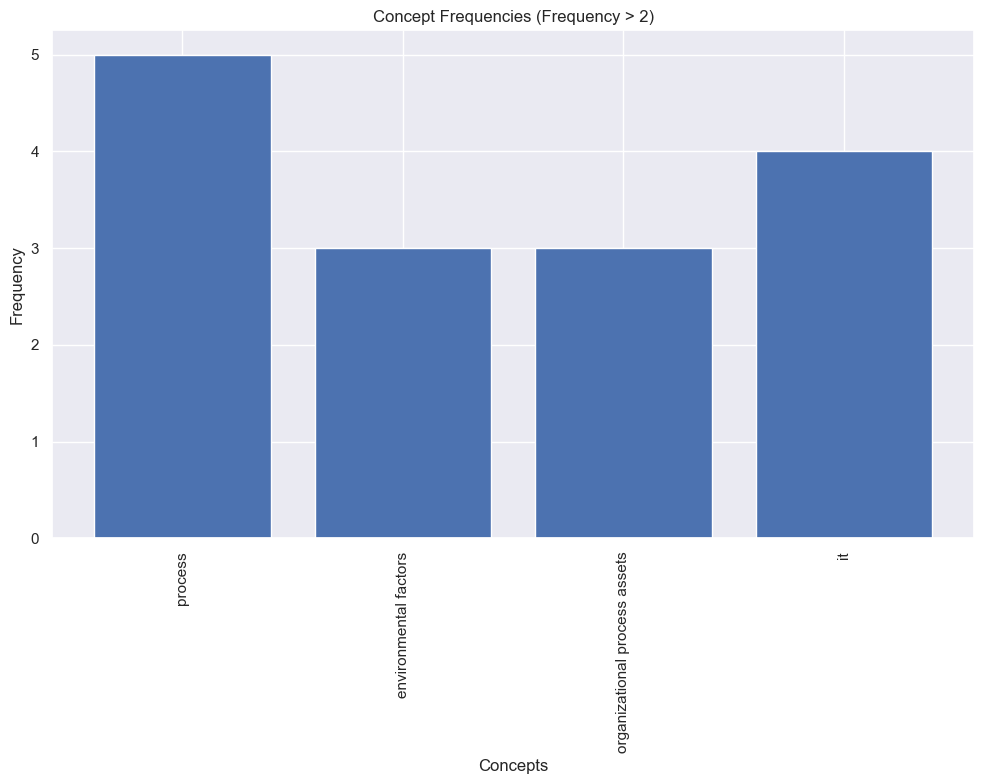

In [42]:
import matplotlib.pyplot as plt
from collections import Counter

# Your concatenated_values_reset Series
concept_freq = Counter(concatenated_values)

# Filter out concepts with frequency less than or equal to 2
filtered_concept_freq = {concept: freq for concept, freq in concept_freq.items() if freq > 2}

# Plot the filtered concept frequencies
plt.figure(figsize=(10, 8))
plt.bar(filtered_concept_freq.keys(), filtered_concept_freq.values())
plt.xlabel("Concepts")
plt.ylabel("Frequency")
plt.title("Concept Frequencies (Frequency > 2)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
